# Example of Linear Regression using GapMinder Data

As a very simple example of machine learning we're going see if we can predict life expectancy using some data from [GapMinder](https://www.gapminder.org/tools/#_data_/_lastModified:1526038652718&lastModified:1526038652718;&chart-type=bubbles), an organisation that aims to educate us more on the true state of the world.
The input data set will have the following variables:
- Country - 136 countries are included 
- Continent
- Life expectancy
- GDP per capita, PPP, inflation adjusted
- Healthcare spend as a percentage of GDP
- Population per square km 
- The democracy index of the country (high is better). See https://en.wikipedia.org/wiki/Democracy_Index

Go to [GapMinder](https://www.gapminder.org/tools/#_data_/_lastModified:1526038652718&lastModified:1526038652718;&chart-type=bubbles) now and take a look at some of these variable in the data viewer.  
- Do any of the variables (visually) look like they have a bearing on life expectancy?  
- Are any of them surprising?
- We want the relationship between the variables to be more-or-less astraight line.  Does a log-linear display help? 
<img src="files/Screen Shot from gapminder.png" alt="GDP per Capita vs. Life Expectancy from Gapminder" title="GDP per Capita vs. Life Expectancy from Gapminder" style="width: 50pc;"/>

# Basic Linear Regression Theory
- Straight line equation (indicate dependent vs. independent variable)
- Least squares
- Expand to multiple dimensions
- Link to more detailed explanation

# How do we know which variables to use?
When we have a number of variables, it may not be immediately apparent which ones influence the final result.  We will usually find that we can and should  drop one or more independent variables because:
- We don't want to include variables that aren't significant
<img src="files/GarbageInGarbageOut.png" alt="Garbage In - Garbage out" title="Garbage In - Garbage Out" style="width: 25pc;"/>
- When you are presenting your results you will have to explain why you included a variable; "because I had the data" is not a good enough reason!

There are several ways to acheive but we will concentrate on "backward elimination".  To understand this you need to know about the "P" value.  A proper explanation is [here](https://www.mathbootcamps.com/what-is-a-p-value) but for now we'll just say that the lower the P value is, the more significant the variable.

## Backward elimination
1. Choose a maximum P value: 5% is a good value
2. Run the linear regression using all the dependent variables. 
3. Look at the P values from the output, and choose the biggest.  
4. If it is > than 5%, then drop that variable.
5. Rerun the linear regression.
6. Repeat steps 2-5 until all P-values are < 5%.  

#### I will take you up to step 5, then the rest will be up to you!

# Coding
## Importing the Dataset
Firstly we need to import some libraries

In [1]:
# Standard library for numerical analysis
import numpy as np
# Standard library for data manipulation
import pandas as pd

# User-defined library for making plots
import sys
!mkdir -p local_modules/
!cd local_modules
!wget https://raw.githubusercontent.com/DataForGood-Norway/GirlsCanDoIt/master/MachineLearning/Lab/python/plot_functions.py
!cd ..
sys.path.append('local_modules')
from plot_functions import make_plot

Next we will import the dataset with data for 2007, which has the following columns:
- Country - 136 countries are included
- Continent
- lifeexp - Life expectancy
- gdpPercap - GDP per capita, PPP, inflation adjusted
- health_spend - Healthcare spend as a percentage of GDP
- Pop density - popultaion per square km
- Democracy - The democracy index of the country

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/DataForGood-Norway/GirlsCanDoIt/master/MachineLearning/Lab/datasets/gapminder_2007_emma.csv')
dataset.head(13)

,country,continent,lifeExp,pop,gdpPercap,health_spend,Pop density,Democracy
0,Afghanistan,Asia,43.828,31889923,974.580338,7.3,44.696,NaN
1,Albania,Europe,76.423,3600523,5937.029526,6.9,110.257,9.0
2,Algeria,Africa,72.301,33333216,6223.367465,3.5,14.236,2.0
3,Angola,Africa,42.731,12420476,4797.231267,2.5,14.057,-2.0
4,Argentina,Americas,75.320,40301927,12779.379640,8.4,14.159,8.0
5,Australia,Oceania,81.235,20434176,34435.367440,8.5,2.728,10.0
6,Austria,Europe,79.829,8199783,36126.492700,10.2,99.094,10.0
7,Bahrain,Asia,75.635,708573,29796.048340,3.6,1333.909,-7.0
8,Bangladesh,Asia,64.062,150448339,1391.253792,3.5,999.714,-6.0
9,Belgium,Europe,79.441,10392226,33692.605080,9.6,345.216,8.0


### Data preparation
To get ready for the regression we need to make sure that all the columns contain numbers only:
- Cells that are empty currently contain "Not a Number" (nan) - these will be replaced with an average
- Cells that contain words ("categorical variables") will be replaced with numerical values.

But firstly the data now needs to be split into independent and dependent variables:

In [3]:
# Country, continent, population, GDP per cap, healthcare spend, pop density, democracy
X = dataset.iloc[:,[0,1,3,4,5,6,7]].values
# Will use the log of the GDP per capita because from our first look, there seems to be a log-linear realtionship
X[:,3] = np.log(dataset.iloc[:,4].values)
# The dependent variable is life expectancy, in column 2
y = dataset.iloc[:, 2].values
# Also making a list of continents for plotting purposes
cont = dataset.iloc[:,1].values

## Cleaning
- The cells where data is missing have "Not a Number" in them. The following code replaces these with the average for that column

In [4]:
# Fix the "NaNs" - replace with the average of that column
# sklearn contains libraries for preprocessing data
# now importing Imputer class
from sklearn.preprocessing import Imputer
# Create object
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# Fit imputer object to feature X
imputer = imputer.fit(X[:,2:])
# Replace missing data with replaced values
X[:,2:] = imputer.transform(X[:,2:])

## Categorical variables
Categorical variables are ones which have a name, not a number.  In this case that would "Country name" and "Continent".

### Country name
We only have each country listed once, and it makes no sense to use the name of the country in the regression, so we are somply going to number them 0-136

In [5]:
# now importing LabelEncoder class
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Encoding the Independent Variable
# Firstly assign the categorical variables a unique number using LabelEncoder
labelencoder_X = LabelEncoder()
# Country names are in column zero
# Each country will get a number 0-136 (for the full dataset) 
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X.shape

(136, 7)

### Continent
There are 5 continents in this dataset: Africa, Americas, Asia, Europe and Oceania.  If we simply give them a number 0-4, Python will assume that Oceania "is greater" than all this other continents, which makes no sense.  To fix this we use "one-hot encoding" which works like this:
- Number the continents 0-4
- Create a column for each continent -- these new columns are called __dummy variables__
- If the country is in that continent the column contains "1" otherwise it contains "0"

In [6]:
# now importing OneHotEncoder class
from sklearn.preprocessing import OneHotEncoder
# Each continent will get a number 0-4
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
cont = labelencoder_X.fit_transform(cont)

# one hot encode continents
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X.shape

(136, 11)

## Dummy variable trap
A requirement of regression is that no column can be predicted from the others. Since any of the five columns could be predicted from the other four (known as the __dummy variable trap__) we need to drop one.
    - Normally it would be the first column, but since Africa looks quite interesting in this dataset, I decided to drop Oceania

In [7]:
X = X[:,[0,1,2,3,5,6,7,8,9,10]]

## Add a constant
We need to add a column of ones at the beginning, as the regression requires a constant

In [8]:
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)



## Splitting into tesing and training set
This is very important!  We will first try to create the model from the training set and then apply it to the test set to see if the model has worked.

In [9]:

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test, cont_train, cont_test = train_test_split(X, y, cont, test_size = 0.2, random_state = 0)

"""
Columns are now
0: constant, 1:is Africa 2: is Americas 3: is Asia 4:is Europe
5: country 6:population 7:log(GDP per cap) 
8:health spend 9:pop density 10: dempocracy score
"""

#Finally this is just to give column headers to the datasets 
X_train = pd.DataFrame(X_train,columns = ['const', 'africa','americas','asia','europe','country',
                                          'population','health_spend','logGDP','pop_density','democracy'])
X_test = pd.DataFrame(X_test,columns = ['const', 'africa','americas','asia','europe','country',
                                          'population','health_spend','logGDP','pop_density','democracy'])

X_train.head()

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,const,africa,americas,asia,europe,country,population,health_spend,logGDP,pop_density,democracy
0,1.0,0.0,0.0,1.0,0.0,108.0,4553009.0,10.760945,3.185626,6712.876,-2.000000
1,1.0,1.0,0.0,0.0,0.0,10.0,8078314.0,7.273290,4.600000,72.034,7.000000
2,1.0,1.0,0.0,0.0,0.0,2.0,33333216.0,8.736066,3.500000,14.236,2.000000
3,1.0,0.0,1.0,0.0,0.0,51.0,7483763.0,8.174233,5.900000,63.868,7.000000
4,1.0,1.0,0.0,0.0,0.0,100.0,798094.0,8.945088,6.551296,325.021,4.210938


## Training the regressor
This is where we get to the interesting part!

Firstly we will train the regressor using all the variables and see how it performs:


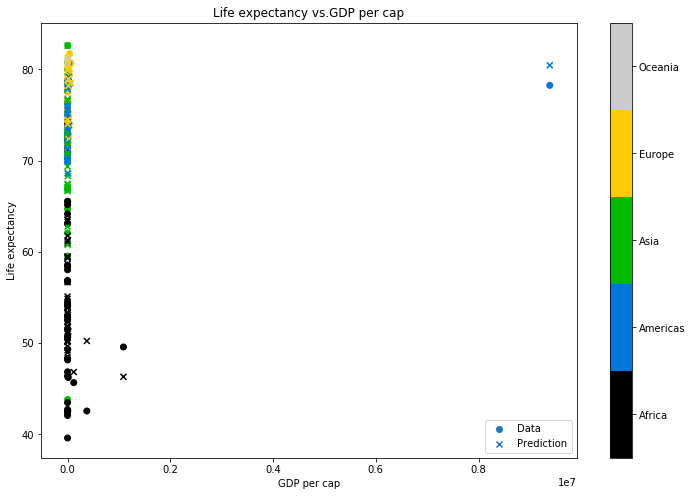

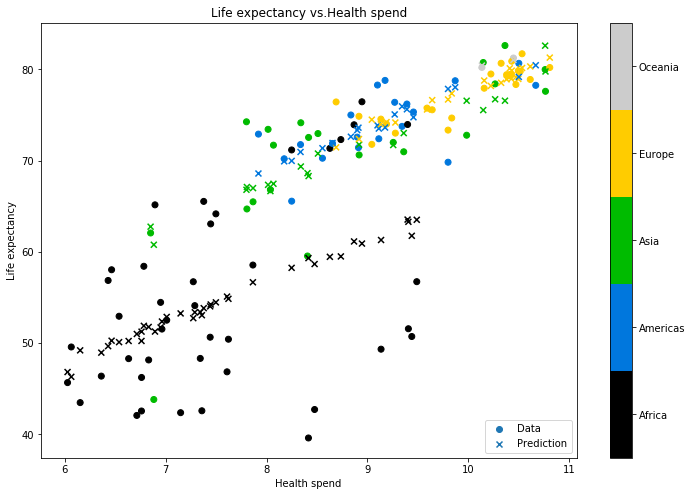

In [14]:
"""Start the training
"""

#train the regressor
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
#Make predictions
y_pred = regressor.predict(X_train)

X_train['logGDP']
#plot the results
make_plot('GDP per cap',np.exp(X_train['logGDP']),y_train,y_pred,cont_train)
#plot the results
make_plot('Health spend',X_train['health_spend'],y_train,y_pred,cont_train)


#### What can we say about the above plots?  
#### Is there a continent that stands out from the rest?

## Start backward elimination
As a reminder:
1. Choose a maximum P value: 5% is a good value
2. Run the linear regression using all the dependent variables.
3. Look at the P values from the output, and choose the biggest.
4. If it is > than 5%, then drop that variable.
5. Rerun the linear regression.
6. Repeat steps 2-5 until all P-values are < 5%.

#### The code below is the first step and then you will have a chance to get involved and complete the other steps.


In [21]:
#Start backward elimination
import statsmodels.formula.api as sm
X_opt = X_train.loc[:,['const', 'africa','americas','asia','europe','country','population',
                    'health_spend','logGDP','pop_density','democracy']]
regressor_OLS = sm.OLS(endog = y_train, 
                       exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     28.69
Date:                Sat, 02 Jun 2018   Prob (F-statistic):           9.53e-25
Time:                        16:01:15   Log-Likelihood:                -351.40
No. Observations:                 108   AIC:                             724.8
Df Residuals:                      97   BIC:                             754.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           36.5923      9.214      3.972      0.000      18.306      54.879
africa         -15.0632      5.374     -2.803      0.006     -25.728      -4.398
americas        -2.0509      5.012     -0.409      0.683     -11.998       7.896
asia            -4.9746      5.329     -0.934      0.353     -15.551       5.602
europe          -2.0982      4.883     -0.430      0.668     -11.790       7.593
country          0.0094      0.016      0.584      0.561      -0.023       0.042
population     1.27e-09   4.07e-09      0.312      0.756   -6.81e-09    9.35e-09
health_spend     4.4054      0.715      6.161      0.000       2.986       5.825
logGDP          -0.1395      0.300     -0.465      0.643      -0.735       0.455
pop_density      0.0004      0.001      0.409      0.684      -0.002       0.003
democracy       -0.0470      0.139     -0.337      0.736      -0.323       0.229
==============================================================================
Omnibus:                        4.983   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                5.722
Skew:                          -0.230   Prob(JB):                       0.0572
Kurtosis:                       4.029   Cond. No.                     3.40e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Look at the table above.  We are particularly interested in the P-values for each variable.  What does this say about the significance of the different variables?  Are any of them surprising?

#### You can plot the results using the user defined module make_plot, which sets some of the display parameters like colour and titles, without you having to type it all in every time.  The format is:
make_plot('independent_variable',x_data,actual_data,predicted data,continents)

In [ ]:
#Make predictions
regressor_new = LinearRegression()
regressor_new.fit(X_opt,y_train)
y_pred = regressor.predict(X_train)

#plot the results
gdp_per_cap = np.exp(X_train[:,7])
make_plot('GDP per cap',gdp_per_cap,y_train,y_pred,cont_train)
#plot the results
make_plot('Health spend',X_train[:,8],y_train,y_pred,cont_train)